# EDA Notebook
this notebook is focusing on understanding the data and its structure. 

> note: for convenience, the first 2 cellblocks are to be seen before the imports, as to avoid running long code by mistake. The data is then saved in a smaller .csv file, which is used for the model training and predictions. 

First version of the model is created for testing purposes. 

Data source: 
https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions?resource=download&select=credit_card_transactions-ibm_v2.csv

In [ ]:
# data is too large, for loading on small RAM use chunk
chunk = 10000
dflist = []
for df in pd.read_csv('./data/cc_ibm.csv', chunksize=chunk):
    dflist.append(df)

# create a large dataframe
ibm = pd.concat(dflist)
ibm.head()

In [5]:
years = np.arange(2002, 2021)
dfs = []

# sort out the relevant years: 4 years from the last period
for year in years[13:]:
    df = ibm.loc[ibm['Year'] == year]
    dfs.append(df)


In [ ]:
# save it for later (the original file is very large)
data = pd.concat(dfs[-6:])
data.to_csv('ibm_6y.csv', index=False)
data.head()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import seaborn as sns


In [3]:
data = pd.read_csv('../data/ibm_4y.csv')
print(data.shape)
data.head()

(5505413, 15)


,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2017,1,3,06:56,$28.06,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942,NaN,No
1,0,0,2017,1,4,06:35,$46.07,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912,NaN,No
2,0,0,2017,1,6,05:47,$31.08,Chip Transaction,4060646732831064559,La Verne,CA,91750.0,5411,NaN,No
3,0,0,2017,1,7,13:26,$11.48,Chip Transaction,-4500542936415012428,La Verne,CA,91750.0,5814,NaN,No
4,0,0,2017,1,8,06:37,$39.69,Chip Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


### EDA and Cleaning

MCC codes are four-digit numbers that classify a business by the services it provides or products it sells. If a business has a variety of products or services, the MCC code is usually based on the product or service that makes up the bulk of the business’ sales. (https://www.heartland.us/resources/blog/merchants-guide-to-mcc-codes)

In [4]:
data.rename(str.lower, axis='columns', inplace=True)
data.rename(columns={'use chip': 'use_chip', 
                       'merchant name': 'merchant_name', 
                       'merchant city': 'merchant_city', 
                       'merchant state': 'merchant_state',
                       'errors?': 'errors', 
                       'is fraud?': 'is_fraud' }, 
                       inplace=True)
data.head()


,user,card,year,month,day,time,amount,use_chip,merchant_name,merchant_city,merchant_state,zip,mcc,errors,is_fraud
0,0,0,2017,1,3,06:56,$28.06,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942,NaN,No
1,0,0,2017,1,4,06:35,$46.07,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912,NaN,No
2,0,0,2017,1,6,05:47,$31.08,Chip Transaction,4060646732831064559,La Verne,CA,91750.0,5411,NaN,No
3,0,0,2017,1,7,13:26,$11.48,Chip Transaction,-4500542936415012428,La Verne,CA,91750.0,5814,NaN,No
4,0,0,2017,1,8,06:37,$39.69,Chip Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [5]:
# set time series index
data[['hour', 'minute']] = data['time'].str.split(':', expand=True)
data['date'] = pd.to_datetime(data[['year', 'month', 'day', 'hour', 'minute']])
data.set_index('date', inplace=True)
#data.drop(columns=['year', 'month', 'day', 'time', 'hour', 'minute'], inplace=True)

# convert amount to float
data['amount'] = data['amount'].str[1:].astype('float64')
data.head()



,user,card,year,month,day,time,amount,use_chip,merchant_name,merchant_city,merchant_state,zip,mcc,errors,is_fraud,hour,minute
date,,,,,,,,,,,,,,,,,
2017-01-03 06:56:00,0,0,2017,1,3,06:56,28.06,Chip Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942,NaN,No,06,56
2017-01-04 06:35:00,0,0,2017,1,4,06:35,46.07,Chip Transaction,-34551508091458520,La Verne,CA,91750.0,5912,NaN,No,06,35
2017-01-06 05:47:00,0,0,2017,1,6,05:47,31.08,Chip Transaction,4060646732831064559,La Verne,CA,91750.0,5411,NaN,No,05,47
2017-01-07 13:26:00,0,0,2017,1,7,13:26,11.48,Chip Transaction,-4500542936415012428,La Verne,CA,91750.0,5814,NaN,No,13,26
2017-01-08 06:37:00,0,0,2017,1,8,06:37,39.69,Chip Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No,06,37


In [ ]:
# check that the dates are sequential:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize= (8, 4))
ax1.plot(data['year'])
ax2.plot(data['month'])
ax3.plot(data['day'])


In [6]:
# from the charts, the years and months are sequential, 
# however the dates inside every single month are mixed up. 
data.sort_index(inplace=True)

In [ ]:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize= (8, 4))
ax1.plot(data['year'])
ax2.plot(data['month'])
ax3.plot(data['day'])

In [7]:
data.drop(columns=[ 'time'], inplace=True)
data.isna().sum()

user                    0
card                    0
year                    0
month                   0
day                     0
amount                  0
use_chip                0
merchant_name           0
merchant_city           0
merchant_state     688653
zip                726686
mcc                     0
errors            5418352
is_fraud                0
hour                    0
minute                  0
dtype: int64

In [ ]:
# number of fraud transactions: 4,833
data.loc[data['is_fraud'] == 'Yes']

In [ ]:
# many missing values in errors: most of the transactions are without errors.
data['errors'].value_counts()       #total 87K errors


In [8]:
# check connection between errors, error types, and frauds:
data['errors'].loc[data['is_fraud'] == 'Yes' ].groupby(data['errors'].loc[data['is_fraud'] == 'Yes' ].index.year).value_counts()


# no significant correlation between fraud/errors, errors are of different kinds. 

date  errors                      
2017  Bad PIN                          8
      Insufficient Balance             3
2018  Bad PIN                         69
      Insufficient Balance            28
      Technical Glitch                 9
      Bad CVV                          2
      Bad Expiration                   1
2019  Bad PIN                         40
      Insufficient Balance            16
      Bad PIN,Insufficient Balance     1
      Technical Glitch                 1
Name: count, dtype: int64

In [9]:
data['user'].groupby(data.index.year).agg('count')
# 2020 only until 03-2020 - beginning of Covid. 

date
2017    1723360
2018    1721615
2019    1723938
2020     336500
Name: user, dtype: int64

In [10]:
# check transaction type (use_chip)
data.groupby([data.index.year, 'use_chip'])['use_chip'].value_counts()  
 
# about same % of online transactions from total as other years.

date  use_chip          
2017  Chip Transaction      1217817
      Online Transaction     213658
      Swipe Transaction      291885
2018  Chip Transaction      1215055
      Online Transaction     213632
      Swipe Transaction      292928
2019  Chip Transaction      1217608
      Online Transaction     213953
      Swipe Transaction      292377
2020  Chip Transaction       235863
      Online Transaction      42684
      Swipe Transaction       57953
Name: count, dtype: int64

In [11]:
# all the merchant state missing values are online transactions. 
data.loc[data['merchant_state'].isna()].groupby('merchant_city').count()

,user,card,year,month,day,amount,use_chip,merchant_name,merchant_state,zip,mcc,errors,is_fraud,hour,minute
merchant_city,,,,,,,,,,,,,,,
ONLINE,688653,688653,688653,688653,688653,688653,688653,688653,0,0,688653,15501,688653,688653,688653


In [12]:
# online transactions have no zipcode and no state. 
# a bit over 12% [4.7K/38K] of the transactions are fraud with missing zipcode but on premise. 
data.loc[(data['zip'].isna() == True) & (data['merchant_state'].isna() == False)].groupby('is_fraud').count()

,user,card,year,month,day,amount,use_chip,merchant_name,merchant_city,merchant_state,zip,mcc,errors,hour,minute
is_fraud,,,,,,,,,,,,,,,
No,33351,33351,33351,33351,33351,33351,33351,33351,33351,33351,0,33351,408,33351,33351
Yes,4682,4682,4682,4682,4682,4682,4682,4682,4682,4682,0,4682,175,4682,4682


In [13]:
# compare to the fraud rate from the total transactions:

data['is_fraud'].value_counts() / data.shape[0]
# many more frauds without zip code (but not online) than in the total dataset. 

is_fraud
No     0.999122
Yes    0.000878
Name: count, dtype: float64

In [ ]:
data.loc[(data['zip'].isna() == True)& (data['merchant_state'].isna() == False)].nunique()    
# more than half the users have deals without zip code, through the year

In [14]:
# all the fraud cases without zip codes come from Rome, Italy
no_zip = data.loc[(data['zip'].isna() == True)& (data['merchant_state'].isna() == False)]
cities_with_no_zip = []
cities_with_other_zips = []
for city in no_zip['merchant_city'].value_counts().index:
    x = data.loc[data['merchant_city'] == city]['zip'].nunique()
    f = data.loc[data['merchant_city'] == city]['is_fraud'].value_counts()
    if 'Yes' in f.index:
         print(f)
         print(f'{city}: different zips: {x}')
    if x == 0:
         cities_with_no_zip.append(x)
    else:
         cities_with_other_zips.append(x)


is_fraud
Yes    4682
No     2619
Name: count, dtype: int64
Rome: different zips: 7


In [ ]:
no_zip.loc[no_zip['merchant_city'] == 'Rome'].groupby('is_fraud').count()

# there's also Rome city in NY. all the zip codes from Rome, It are NA. 
# total deals from rome for the yesrs: 5,700. so most of the data fro Rome is Fraud.

In [ ]:
data.loc[(data['merchant_city'] == 'Rome') & (data.index.year == 2020)]

In [ ]:
data.loc[(data['merchant_city'] != 'Rome') & (data['merchant_state'] == 'Italy') & (data['zip'].isna() == False)]
# no other cities in Italy in the data. 


In [15]:
data['amount'].groupby(data['is_fraud']).sum()


is_fraud
No     2.350539e+08
Yes    3.856624e+05
Name: amount, dtype: float64

Text(0.5, 1.0, 'amount per transaction')

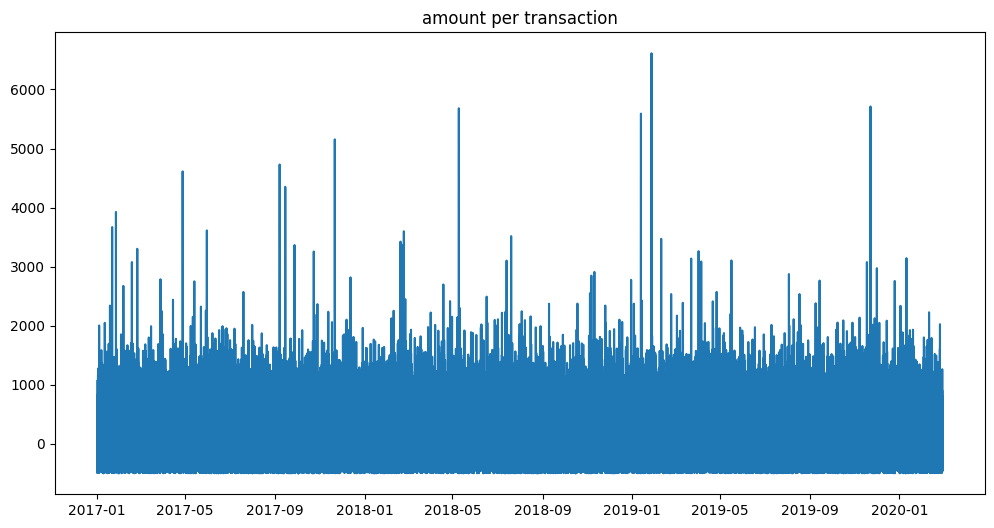

In [16]:
fig = plt.figure( figsize=(12, 6))
plt.plot(data['amount'])
plt.title('amount per transaction')

Text(0.5, 0.01, 'Transaction amount')

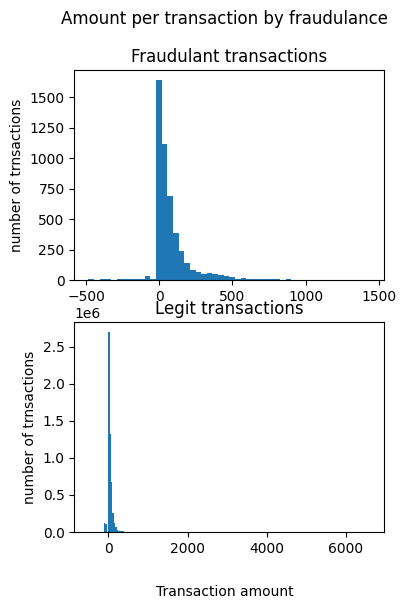

In [21]:
fraud = data.loc[data['is_fraud'] == 'Yes']
normal = data.loc[data['is_fraud'] == 'No']
fig, axs = plt.subplots(2, 1, sharex=False, figsize= (4, 6))
fig.suptitle('Amount per transaction by fraudulance')
axs[0].hist(fraud['amount'], bins = 50)
axs[0].set_title('Fraudulant transactions')
axs[0].set_ylabel('number of trnsactions')

axs[1].hist(normal['amount'], bins = 200)
axs[1].set_title('Legit transactions')
axs[1].set_ylabel('number of trnsactions')
fig.text(0.5, 0.01, 'Transaction amount', ha='center', va='center')

In [22]:
data.loc[(data['amount'] < 0.1) & (data['is_fraud'] == 'Yes' )]     # 276K transactions with negative amounts, 178 are fraud. 
normal['amount'].nlargest(5)              # there are several transactions with very large amounts of >5K that make the hist seem empty. fraud: max - 1442

date
2019-01-27 17:52:00    6613.44
2019-11-22 14:49:00    5712.06
2018-05-09 17:38:00    5682.22
2019-01-13 07:09:00    5591.73
2017-11-21 09:19:00    5155.36
Name: amount, dtype: float64

Text(0.02, 0.5, 'Aggregated amount per user')

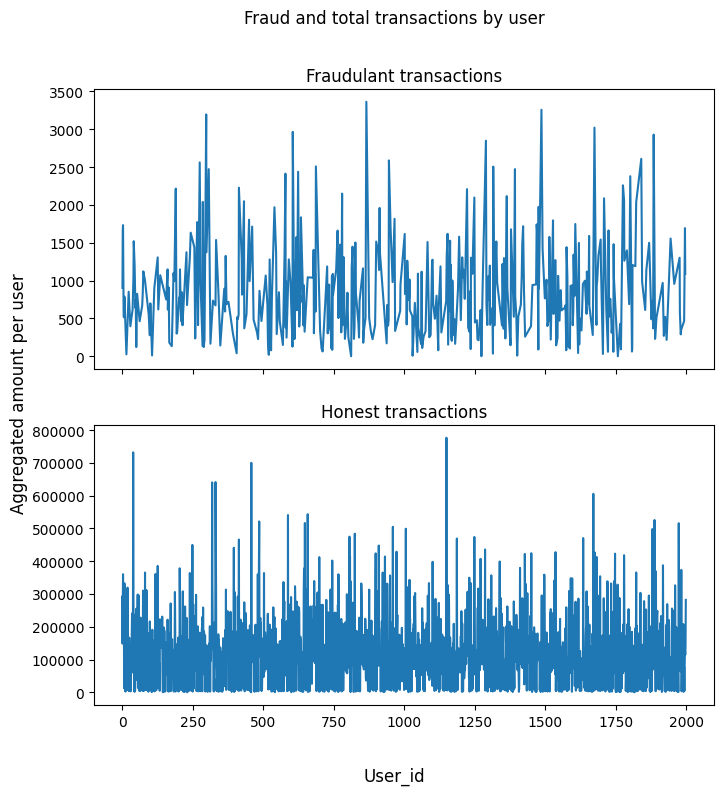

In [24]:
data['amount'].groupby(data['user']).sum()
fig, axs = plt.subplots(2, 1, sharex=True, figsize= (8, 8))
fig.suptitle('Fraud and total transactions by user')
axs[0].plot( fraud['amount'].groupby(fraud['user']).sum())
axs[0].set_title('Fraudulant transactions')
axs[1].plot(normal['amount'].groupby(normal['user']).sum())
axs[1].set_title('Honest transactions')

fig.supxlabel('User_id')
fig.supylabel('Aggregated amount per user')


Text(0.02, 0.5, 'Transaction amount')

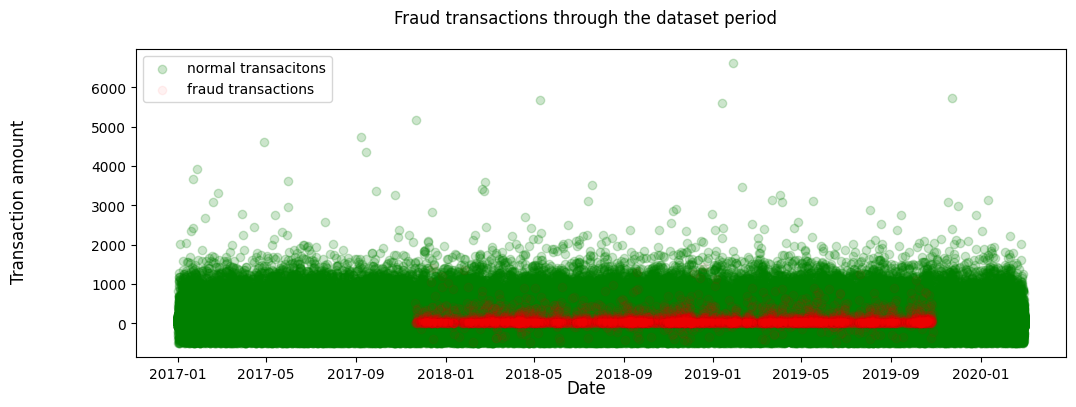

In [26]:
# fraud accross time

fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(normal.index, normal['amount'], color='g', alpha=0.2, label='normal transacitons')
ax.legend("Honest transactions")
ax.scatter(fraud.index, fraud['amount'],color='r', alpha=0.05, label='fraud transactions')
ax.legend()
fig.suptitle('Fraud transactions through the dataset period')
fig.supxlabel('Date')
fig.supylabel('Transaction amount')


In [ ]:
fig, ax = plt.subplots(figsize=(17, 4))
fig.suptitle('Fraud patterns relative to normal deal patterns')
ax.plot(fraud['amount'],color='r', alpha=0.9, label='Fraud')
ax.plot(normal['amount'], color='g', alpha=0.2, label='Normal')
ax.set_xlabel('Time')
ax.set_ylabel('Amount')

In [ ]:
# number of transactions per month, legit and fraud
m_fraud = fraud[['amount']].groupby([fraud.index.month.rename('month'), fraud.index.year.rename('year')]).count()
m_normal = normal[['amount']].groupby([normal.index.month.rename('month'), normal.index.year.rename('year')]).count()
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(m_fraud, bins=m_fraud.shape[0], color='r')
ax.hist(m_normal, bins=m_normal.shape[0], color='g', alpha=0.2)

In [ ]:
# users with more than one fraud: 
f_users = fraud[['user', 'amount']].groupby('user').count()
check_users = normal[['user', 'amount']].groupby('user').count()
norm_users = normal[['user', 'amount']].loc[normal['user'].isin(f_users.index) == True].groupby('user').count()
f = plt.subplots(figsize=(18, 4))
plt.title('Count of fraud per user')
plt.xlabel('user ID')
plt.ylabel('number of transactions transactions')
plt.bar(height=norm_users['amount'], x=norm_users.index, color='g', width=5, label='normal')
plt.bar(height=f_users['amount'], x=f_users.index, color='r', width=5, label='fraudulant')
plt.legend()



In [31]:

f_users.rename(columns={'amount': 'f_amount'}, inplace=True)
f_users
f_users['h_amount'] = norm_users['amount']

In [ ]:
fig = plt.figure(figsize=(17,6)) 

ax = fig.add_subplot(1,1,1) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
fig.suptitle("correlation of number of legit/fraud transaction by user")
width = 0.4

f_users.h_amount.plot(kind='bar', color='green', ax=ax, width=width, position=1)
f_users.f_amount.plot(kind='bar', color='red', ax=ax2, width=width, position=0)

ax.set_ylabel('legit transactions per user')
ax2.set_ylabel('number of fraud transactions per user')

plt.show()

In [ ]:
norm_users.shape, f_users.shape, check_users.shape, normal.shape, fraud.shape, data.shape

### PCA - coding and normalizing 

Train tess split: since 2020 is not a full year, test data will be taken out of 2019. 

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [10]:
X = data.drop(columns=['is_fraud'])
y = data[['is_fraud']]

In [11]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                y, 
                                                test_size=0.25, 
                                                random_state=42, 
                                                shuffle=True, 
                                                stratify=y)     #test size default 25%

In [ ]:
Xtrain.shape

In [ ]:
Xtest.head()

In [14]:

label_enc = LabelEncoder()

# replace missing values with a constant text, then encode to numeric classes and scale
state_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='online')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())])

# replace missing values with zero, then encode and scale
zero_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())
])

# implement number scaler on numerical features (no missing values)
# implement text replacement to state and errors
# implement zero replacement to zip, city and chip
transformer= ColumnTransformer(
    transformers=[
        ('number_scaler', StandardScaler(), [0, 1, 2, 3, 4, 5, 7, 11, 13, 14]),
        ('NAN_replace_text', state_pipe, [9, 12]),
        ('NAN_replace_zero', zero_pipe, [6, 8, 10]),
        
    ], remainder='drop', verbose_feature_names_out=False)        # pipeline(memory='dirpath to cache)


In [ ]:
ytrain = label_enc.fit_transform(ytrain)
transformer.fit(Xtrain)
Xtrain = transformer.transform(Xtrain)
Xtest = transformer.transform(Xtest)

In [16]:
xtrain, xval = train_test_split(Xtrain, test_size=0.2, shuffle=False)
ytrain, yval = train_test_split(ytrain, test_size=0.2, shuffle=False)

In [ ]:
xtrain.shape, ytrain.shape, xval.shape, yval.shape, Xtest.shape, ytest.shape

In [19]:
# reshaping labels tensor to fit the model requirements of 2 dimensions
ytrain = ytrain.reshape(ytrain.shape[0], 1)
yval = yval.reshape(yval.shape[0], 1)


In [ ]:
ytrain.ndim

Correlation matrix and distributions: 
(already at this phase it is presumed that the data is quite biased - 
looks like a fraud group from Rome, Italy found its way into the data and made many fraudulant 
transactions)

In [49]:
#import seaborn as sns
sns.set_style('darkgrid')

In [50]:
train_features = pd.DataFrame(xtrain, columns=X.columns).corr(method='spearman')

In [ ]:
fig,ax = plt.subplots(figsize = (12,8))
sns.heatmap(train_features,
            cmap = "coolwarm",
            annot = True,
            annot_kws = {"fontsize":6, "fontweight":"bold"},
            square = True,
            linewidths = 1.0,
            linecolor = "white",
            ax = ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation = -60)
ax.set_title('Correlation Matrix ', fontsize = 10, fontweight = 'bold', color = 'darkblue')
fig.show()



### Model Creation

In [ ]:
import tensorflow as tf
from tensorflow import keras
import mlflow
import datetime
import os
import tempfile


In [ ]:
input_dim = Xtrain.shape[1]
input_dim, Xtrain.shape


In [111]:
METRICS = {
      'binary_crossentropy': keras.metrics.BinaryCrossentropy(name='binary_crossentropy'),  # same as model's loss
      'Brier_score': keras.metrics.MeanSquaredError(name='Brier_score'),
      'tp':keras.metrics.TruePositives(name='tp'),
      'fp':keras.metrics.FalsePositives(name='fp'),
      'tn':keras.metrics.TrueNegatives(name='tn'),
      'fn':keras.metrics.FalseNegatives(name='fn'), 
      'accuracy':keras.metrics.BinaryAccuracy(name='accuracy'),
      'precision':keras.metrics.Precision(name='precision'),
      'recall':keras.metrics.Recall(name='recall'),
      'auc':keras.metrics.AUC(name='auc'),
      'prc':keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
}


In [ ]:
xtrain.shape[0] + xval.shape[0] + Xtest.shape[0], data.shape[0], xtrain.shape[-1]

In [115]:
def create_model(metrics=METRICS, output_bias=None):
    if output_bias:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.Input(shape=(xtrain.shape[-1],)),
        keras.layers.Dense(
            16,
            activation='relu',
        ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
                           bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3,),
        loss=keras.losses.BinaryCrossentropy(),                 ### why does BinaryCrossentropy has a shape problem???????/
        metrics=list(metrics.values())
    )

    return model

In [116]:
EPOCHS = 100
BATCH_SIZE = 2048

eraly_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

log_callback = tf.keras.callbacks.TensorBoard(#log_dir=logdir, 
                                    write_graph=True, 
                                    histogram_freq=1)

In [117]:
params = {
    'EPOCHS' : 100,
    'BATCH_SIZE': 2048,
    #'callbacks': [eraly_stopping, log_callback]
    }

In [ ]:
model = create_model()
model.summary()

In [ ]:
#from keras.utils import plot_model
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# testrun before training
model.predict(xtrain[:10]).ndim


In [ ]:
results = model.evaluate(xtrain, ytrain, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


set an initial bias percentage in order to offset the bias in the data.
This will be smoothed out with a log, which will decrease the inherant loss at the start

In [ ]:
neg, pos = np.bincount(label_enc.transform(y))
sum = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    sum, pos, 100 * pos / sum))


In [ ]:
# set initial bias (ofsetting the effect of biased dataset with less than 1% fraud cases)
initial_bias = np.log([pos/neg])
initial_bias

In [ ]:
model = create_model(output_bias=initial_bias)
model.predict(xtrain[:10])

In [ ]:
results = model.evaluate(xtrain, ytrain, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


In [123]:
# checkpoint weights
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights.weights.h5')
model.save_weights(initial_weights)


In [ ]:
# create model from the saved weights, with initial bias 0
model = create_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    xtrain,
    ytrain,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(xval, yval),
    verbose=1
)

In [ ]:
# model from saved weights with initial bias set.
model = create_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    xtrain,
    ytrain,
    batch_size=params['BATCH_SIZE'],
    epochs=10,
    validation_data=(xval, yval),
    verbose=1,
    callbacks=[log_callback]
)

In [ ]:
careful_bias_history.history.keys()
careful_bias_history.history['accuracy']


In [54]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [55]:
def plot_loss(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'],
                 color=colors[n], label='Train' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
                 color=colors[n], label='val' + label,
                 linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


In [ ]:
plot_loss(zero_bias_history, 'Zero bias', 0)
plot_loss(careful_bias_history, 'Careful bias', 1)

### Training

In [ ]:
# names for MLFLOW runs
experiment = 'baseline'
run_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
logdir = os.path.join("logs", experiment, run_name)
os.makedirs(logdir, exist_ok=True)


model = create_model()
model.load_weights(initial_weights)



with mlflow.start_run(run_name=run_name) as run: 
    mlflow.set_experiment_tag('baseline', 'fraud_analysis')    

    baseline_history = model.fit(
        xtrain,
        ytrain,
        batch_size=params['BATCH_SIZE'],
        epochs=params['EPOCHS'],
        callbacks=[eraly_stopping, log_callback],
        validation_data=(xval, yval)
    )
    run_id = run.info.run_id

### Evaluation

In [ ]:

with mlflow.start_run(run_name=run_name) as run:
    mlflow.set_experiment_tag('baseline', 'fraud_analysis')
    mlflow.set_tag("optimizer", 'keras.optimizer.Adam')
    mlflow.set_tag("loss", "binary_cross_entropy")

    mlflow.keras.log_model(model, "model")

    mlflow.log_params(params)
    #mlflow.log_metrics(METRICS)
    for key, value in METRICS.items(): 
        mlflow.log_metric(key, value)
    mlflow.log_artifact("model.png", "model_plot")

    run_id = run.info.run_id
    print("MLFlow Run ID: ", run_id)

In [58]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    fig = plt.figure(figsize=(20, 8))
    for i, metric in enumerate(metrics):
        name = metric.replace("_", " ")
        plt.subplot(2, 2, i+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle='--', label="val")
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

In [ ]:
plot_metrics(baseline_history)

In [ ]:
train_pred_baseline = model.predict(xtrain, batch_size=BATCH_SIZE)
test_pred_baseline = model.predict(Xtest, batch_size=BATCH_SIZE)

In [ ]:
ytest = label_enc.transform(ytest)
ytest = ytest.reshape(ytest.shape[0], 1)
ytest.ndim

In [63]:
def plot_cm(labels, predictions, threshold=0.5):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion matrix @{threshold:.2f}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    print('Legit transactions detected (True neg):', cm[0][0])
    print('Legit transactions incorrect detected (False pos):', cm[0][1])
    print('Fraud transactions missed (False neg):', cm[1][0])
    print('Fraud transactions detected (True Pos):', cm[1][1])
    print('Total fraud transactions:', np.sum(cm[1]))

In [ ]:
baseline_results = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE, verbose=1)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()
plot_cm(ytest, test_pred_baseline)

In [ ]:
plot_cm(ytest, test_pred_baseline, threshold=0.1)
plot_cm(ytest, test_pred_baseline, threshold=0.01)

In [111]:
#ROC - Receiver Operator Characteristic- 
#TPR vs FPR at various threshold values: separates the 'signal' from the 'noise'.)
#true positive rate (TPR) on the Y axis, and false positive rate (FPR) on the X axis
def plot_roc(name, labels, preds, **kwargs):        
    fpr, tpr, _ = metrics.roc_curve(labels, preds)            # _ for thresholds
    #metrics.RocCurveDisplay.from_predictions(labels, preds, pos_label= 'Detected Fraud', name=name)
    print(len(fpr))
   
    print(len(tpr))
    plt.plot(100*fpr, 100*tpr, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,25])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

    return fpr, tpr

    


In [ ]:
train_fp, train_tp = plot_roc('Train Baseline', ytrain, train_pred_baseline, color=colors[0])
test_fp, test_tp = plot_roc('Test baseline', ytest, test_pred_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

plot area under the curve: AUPRC - area under the percision-recall 

In [90]:
def plot_prc(name, labels, preds, **kwargs):
    precision, recall, _ = metrics.precision_recall_curve(labels, preds)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
plot_prc('Train baseline', ytrain, train_pred_baseline, color=colors[0])
plot_prc('Test baseline', ytest, test_pred_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
weight_0 = (1 / neg) * (sum / 2.0)
weight_1 = (1 / pos) * (sum / 2.0)

class_weight = {0: weight_0, 1: weight_1}

print(f'weight class 0: {weight_0:.2f}')
print(f'weight class 1: {weight_1:.2f}')

Training with class weight: 

In [ ]:
weighted_model = create_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    xtrain,
    ytrain,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[eraly_stopping],
    validation_data=(xval, yval),
    class_weight=class_weight
)

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_pred_weighted = weighted_model.predict(xtrain, batch_size=BATCH_SIZE)
test_pred_weighted = weighted_model.predict(Xtest, batch_size=BATCH_SIZE)

In [ ]:
train_pred_baseline.shape, train_pred_weighted.shape

In [126]:
weighted_results = weighted_model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE, verbose=0)

In [ ]:
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()
plot_cm(ytest, test_pred_weighted)

In [ ]:
plot_roc('Train baseline', ytrain, train_pred_baseline, color=colors[0])
plot_roc('Train baseline', ytest, test_pred_baseline, color=colors[0], linestyle='--')

plot_roc('Test weighted', ytrain, train_pred_weighted, color=colors[1])
plot_roc('Test weighted', ytest, test_pred_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

In [ ]:
plot_prc('Train baseline', ytrain, train_pred_baseline, color=colors[0])
plot_prc('Train baseline', ytest, test_pred_baseline, color=colors[0], linestyle='--')

plot_prc('Test weighted', ytrain, train_pred_weighted, color=colors[1])
plot_prc('Test weighted', ytest, test_pred_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')